In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as metrics
import graphviz
from sklearn import tree

In [2]:
plt.rcParams["figure.figsize"] = (15,10)

#### 1. Consider a set of points (n elements) with a total of c classes. Let us denote the fraction of records that belong to class i at a given node n as p(i|n). Some popular measure of impurity include the following (Erosa's part):

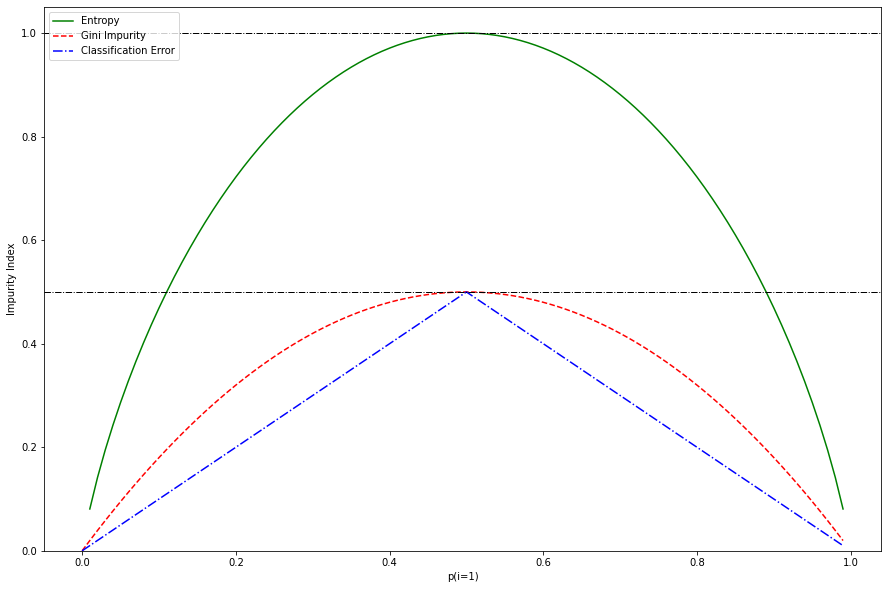

In [3]:
# First we mathematically create the Entropy, Gini and Classification Error Functions
def entropy(p):
    return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def gini(p):
    return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def classification_error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

# Consider that you only has two classes (0,1). Make a plot of the different impurity measures as a function of p(1|n)
ent = [entropy(p) if p != 0 else None for p in x]

# Just in case we want the entropy scaled with a 0.5 peak like gini and ce
# entropy_scaled = [e*0.5 if e else None for e in ent]

c_err = [classification_error(i) for i in x]

# Easier to manage with subplots 
fig = plt.figure()
ax = plt.subplot()

# Plotting with created functions, labels, linestyles and colors
for i, label, linestyle, c, in zip(
      [ent, gini(x), c_err],
      ['Entropy','Gini Impurity', 'Classification Error'],
      ['-', '--', '-.'],
      ['green', 'red', 'blue']):
    line = ax.plot(x, i, label=label, linestyle=linestyle, color=c)

# Label location    
ax.legend(loc='upper left')

# Gini and Classification Error's peak
ax.axhline(y=0.5, linewidth=1, color='black', linestyle='-.')

# Entropy's peak
ax.axhline(y=1.0, linewidth=1, color='black', linestyle='-.')

plt.ylim([0, 1.05])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

##### Entropy:
Entropy is a measure of purity or a measure of disorder. A high level of entropy indicated a low level of purity. Entropy is measured between 0 and 1.(Depending on the number of classes in your dataset, entropy can be greater than 1 but it means the same thing , a very high level of disorder. 

##### Gini Index:
Gini index or Gini impurity measures the degree or probability of a particular variable being wrongly classified when it is randomly chosen. It is calculated by subtracting the sum of squared probabilities of each class from one. It favors larger partitions and easy to implement whereas information gain favors smaller partitions with distinct values.

##### Classification Error:
Maximum of Error is (1 - 1/n) when records are equally distributed among all classes implying least information.
Minimum of Error is 0 when all records belong to one class, implying most information.

#### 2. Consider the following preprocessing steps:

##### a. Lead the Data into a Pandas Dataframe.

In [4]:
titanic_data = pd.read_csv("../data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### b. Delete the Ticket and Cabin Columns.

In [5]:
titanic_data.drop(["Ticket", "Cabin"], axis = 1, inplace = True)
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


##### c. Drop instance without values in the rest of the Dataframe.

In [6]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

In [7]:
titanic_data.dropna(inplace = True)
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

#### 3. Let us perform data exploration and see the percentage of passengers who survived the disaster, categorized by travelling class and gender:

In [8]:
titanic_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,712.0,448.589888,258.683191,1.00,222.75,445.00000,677.25,891.0000
Survived,712.0,0.404494,0.491139,0.00,0.00,0.00000,1.00,1.0000
Pclass,712.0,2.240169,0.836854,1.00,1.00,2.00000,3.00,3.0000
Age,712.0,29.642093,14.492933,0.42,20.00,28.00000,38.00,80.0000
SibSp,712.0,0.514045,0.930692,0.00,0.00,0.00000,1.00,5.0000
Parch,712.0,0.432584,0.854181,0.00,0.00,0.00000,1.00,6.0000
Fare,712.0,34.567251,52.938648,0.00,8.05,15.64585,33.00,512.3292


In [9]:
cross_tab_Pclass = pd.crosstab(titanic_data.Pclass, columns = titanic_data.Survived)
cross_tab_Pclass

Survived,0,1
Pclass,,
1,64,120
2,90,83
3,270,85


In [10]:
cross_tab_gender = pd.crosstab(titanic_data.Sex, columns = titanic_data.Survived)
cross_tab_gender 

Survived,0,1
Sex,,
female,64,195
male,360,93


#### 4. For modelling only, a subset of the features provided will be used: class, gender and age. Remember that Scikit-learn only takes numerical values.

In [11]:
titanic_subdata = titanic_data[["Pclass","Sex", "Age", "Survived"]].copy()
titanic_subdata.head()

,Pclass,Sex,Age,Survived
0,3,male,22.0,0
1,1,female,38.0,1
2,3,female,26.0,1
3,1,female,35.0,1
4,3,male,35.0,0


##### a. Get dummy variables (get_dummies) from the gender. Append two columns, one called female and the other one called male, indicating the values with 0 and 1.

In [12]:
titanic_subdata["female"] = pd.get_dummies(titanic_subdata.Sex).female
titanic_subdata["male"] = pd.get_dummies(titanic_subdata.Sex).male
titanic_subdata.drop(["Sex"], axis = 1,inplace = True)
titanic_subdata.head()

,Pclass,Age,Survived,female,male
0,3,22.0,0,0,1
1,1,38.0,1,1,0
2,3,26.0,1,1,0
3,1,35.0,1,1,0
4,3,35.0,0,0,1


##### b. Split the dataset into train (70%) and test (30%). Only include one gender column (female or male).

In [13]:
titanic_subdata = titanic_subdata[["Pclass", "male", "Age", "Survived"]]
titanic_subdata.head()

,Pclass,male,Age,Survived
0,3,1,22.0,0
1,1,0,38.0,1
2,3,0,26.0,1
3,1,0,35.0,1
4,3,1,35.0,0


In [14]:
data_titanic = titanic_subdata[["Pclass","male", "Age"]].copy()
target_titanic = titanic_subdata["Survived"].copy()

In [15]:
data_train, data_test, target_train, target_test = train_test_split(data_titanic, target_titanic, train_size = .7, stratify = target_titanic,
                                                                   random_state = 0)

#### 5. Scikit-learn provides a decision tree model in DecisionTreeClassifier(), accepting various parameters such as the impurity criterion taking values such as entropy and gini. We can also affect the pruning with parameters such as max_depth and min_samples_leaf, the former determines the maximum depth (levels) of the tree, whereas the latter determines the minimum number of data instances required to split an internal node.

##### a. Create a two DecisionTreeClassifier() with max_depth = 5 but with different criterion (Gini, Entropy).

In [16]:
Tree_giny = DecisionTreeClassifier(max_depth = 5, criterion = 'gini')
Tree_entropy = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy')

##### b. Compute the confusion matrix and print the Accuracy.

* Giny

In [17]:
Tree_giny.fit(data_train, target_train)
giny_prediction = Tree_giny.predict(data_test)

In [18]:
# Obtain the confusion matrix here
confusion_matrix = metrics.confusion_matrix(target_test, giny_prediction)
confusion_matrix

array([[117,  10],
       [ 31,  56]], dtype=int64)

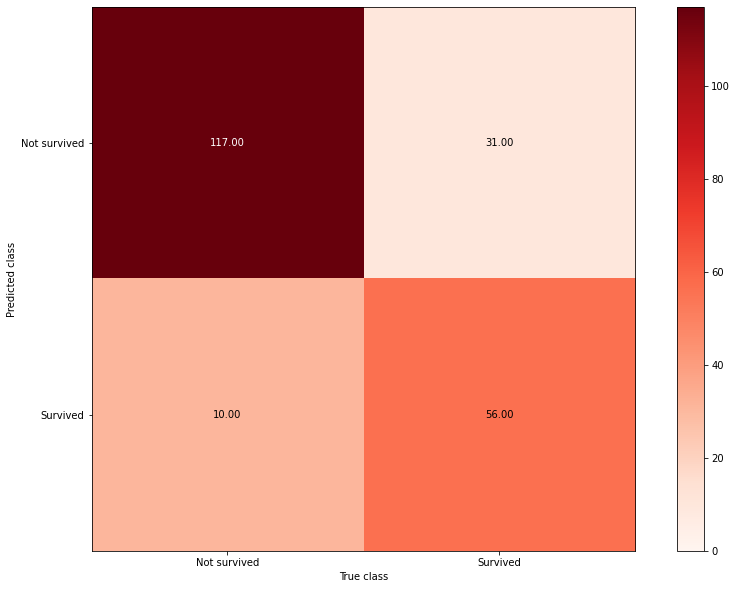

In [19]:
corr_im = plt.imshow(confusion_matrix, cmap="Reds", vmin=0)
corr_cbar = plt.colorbar(corr_im)

corr_array = corr_im.get_array()
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        cell_value = corr_array[i][j]
        if cell_value > 0.5*np.max(confusion_matrix):
            text_color = 'white'
        else:
            text_color = 'black'
        plt.text(i, j, '{:.2f}'.format(cell_value), color=text_color, ha='center', va='center')

plt.xticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])
plt.yticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])

plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.show()

In [20]:
print("Accuracy: ", metrics.accuracy_score(target_test, giny_prediction))

Accuracy:  0.8084112149532711


*  Entropy

In [21]:
Tree_entropy.fit(data_train, target_train)
entropy_prediction = Tree_entropy.predict(data_test)

In [22]:
# Obtain the confusion matrix here
confusion_matrix = metrics.confusion_matrix(target_test, entropy_prediction)
confusion_matrix

array([[117,  10],
       [ 34,  53]], dtype=int64)

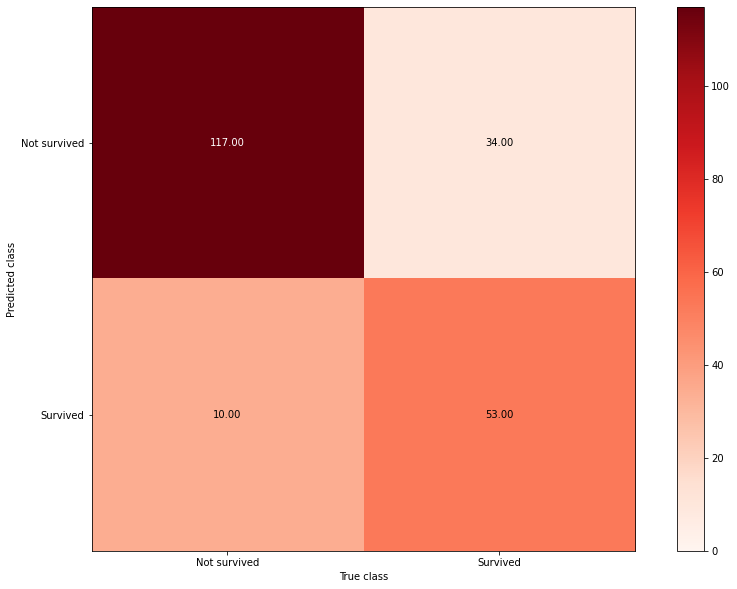

In [23]:
corr_im = plt.imshow(confusion_matrix, cmap="Reds", vmin=0)
corr_cbar = plt.colorbar(corr_im)

corr_array = corr_im.get_array()
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        cell_value = corr_array[i][j]
        if cell_value > 0.5*np.max(confusion_matrix):
            text_color = 'white'
        else:
            text_color = 'black'
        plt.text(i, j, '{:.2f}'.format(cell_value), color=text_color, ha='center', va='center')

plt.xticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])
plt.yticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])

plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.show()

In [24]:
print("Accuracy: ", metrics.accuracy_score(target_test, entropy_prediction))

Accuracy:  0.794392523364486


##### c. Make a visualization of the best Decision Tree with max_depth = 3 using Graphviz.

In [25]:
Tree_giny_3 = DecisionTreeClassifier(max_depth = 3, criterion = 'gini')
Tree_entropy_3 = DecisionTreeClassifier(max_depth = 3, criterion = 'entropy')

In [26]:
Tree_giny_3.fit(data_train, target_train)
giny_prediction_3 = Tree_giny_3.predict(data_test)

Tree_entropy_3.fit(data_train, target_train)
entropy_prediction_3 = Tree_entropy_3.predict(data_test)

In [27]:
print("Accuracy Giny: ", metrics.accuracy_score(target_test, giny_prediction_3))
print("Accuracy Entropy: ", metrics.accuracy_score(target_test, entropy_prediction_3))

Accuracy Giny:  0.8084112149532711
Accuracy Entropy:  0.8084112149532711


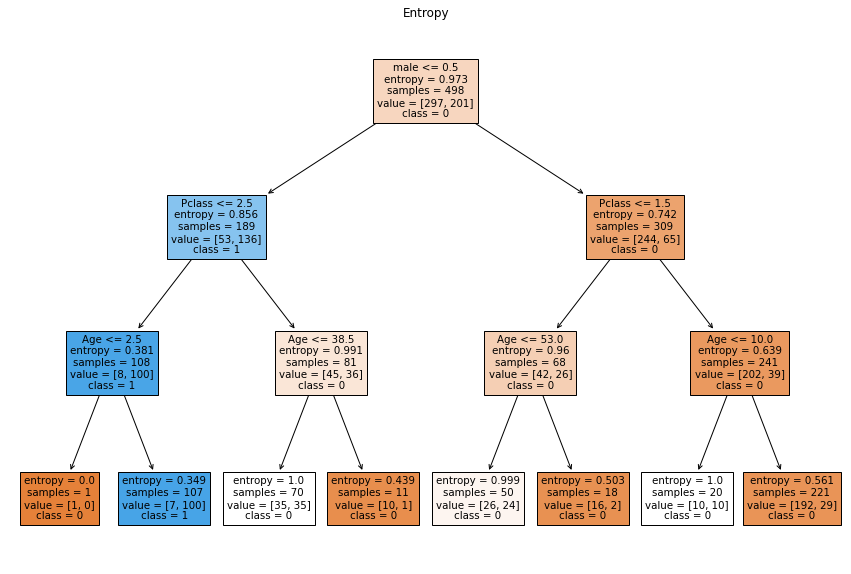

In [28]:
tree.plot_tree(Tree_entropy_3,
               feature_names = ["Pclass", "male", "Age"], 
               class_names= ['0','1'],
               filled = True)
plt.title("Entropy")
plt.show()

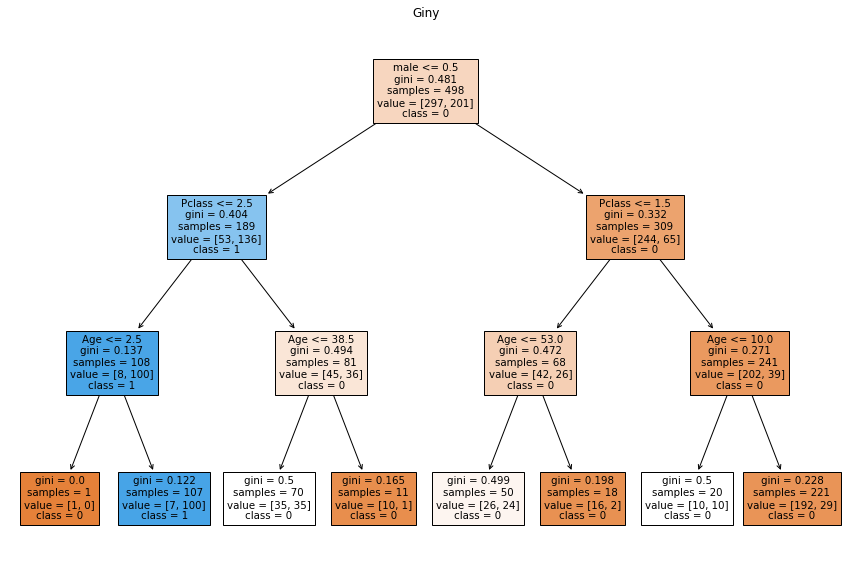

In [29]:
tree.plot_tree(Tree_giny_3,
               feature_names = ["Pclass", "male", "Age"], 
               class_names= ['0','1'],
               filled = True)
plt.title("Giny")
plt.show()

#### 6. Use GridSearchCV (sklearn.model_selection) to determine the best values of the maximum depth and minimum number of samples.

In [30]:
depth_val = np.arange(2,11)
leaf_val = np.arange(1,31, step = 9)
grid_s = [{'max_depth': depth_val,
          'min_samples_leaf': leaf_val}]

model = DecisionTreeClassifier(criterion = 'entropy')

##### a. Run the GridSearchCV with model as estimator, grid_s as param_grid and 10-fold cross validation (cv).

In [31]:
clf = GridSearchCV(model, param_grid = grid_s, n_jobs = -1, cv = 10)

In [32]:
clf.fit(data_titanic, target_titanic)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
             n_jobs=-1,
             param_grid=[{'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                          'min_samples_leaf': array([ 1, 10, 19, 28])}])

##### b. Print the best parameters (“max_depth” and “min_samples_leaf”).

In [33]:
print("Best max depth: ", clf.best_params_['max_depth'])
print("Best min samples leaf: ", clf.best_params_["min_samples_leaf"])

Best max depth:  10
Best min samples leaf:  1


##### c. Create a heatmap of men cross-validation scores for the decision tree classification of the Titanic passenger for different values of maximum depth and minimum sample leaf. It must look like

In [34]:
data = clf.cv_results_['mean_test_score'].reshape(len(depth_val),len(leaf_val)).T
data = np.flip(data, axis = 0)

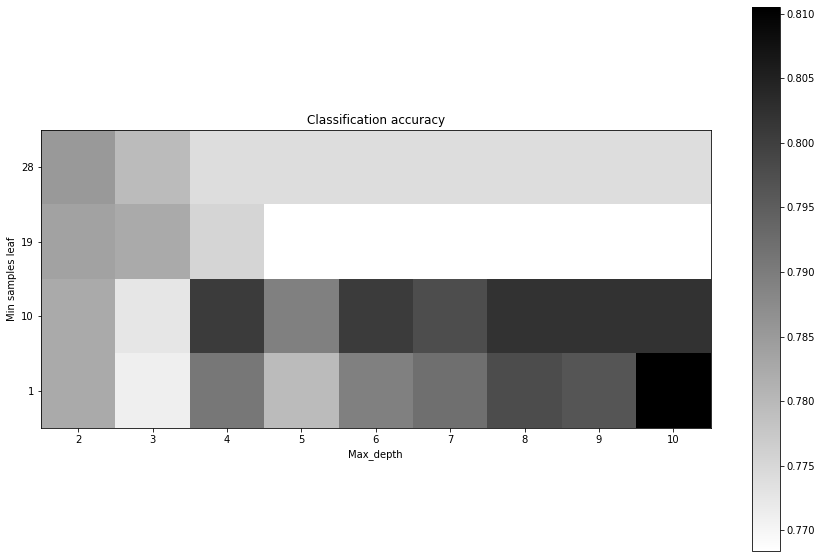

In [35]:
plt.imshow(data, cmap='gray_r')
plt.xlabel('Max_depth')
plt.ylabel('Min samples leaf')
plt.colorbar()
plt.xticks(np.arange(len(depth_val)), depth_val)
plt.yticks(np.arange(len(leaf_val)), np.flip(leaf_val))
plt.title('Classification accuracy')
plt.show()

#### 7. Apply the model to the testing subset:

In [36]:
model_best = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf =  clf.best_params_['min_samples_leaf'], 
                                    max_depth =  clf.best_params_['max_depth'])                                

In [37]:
model_best.fit(data_train, target_train)
prediction_ = model_best.predict(data_test)

In [38]:
# Obtain the confusion matrix here
confusion_matrix = metrics.confusion_matrix(target_test, prediction_)
confusion_matrix

array([[115,  12],
       [ 26,  61]], dtype=int64)

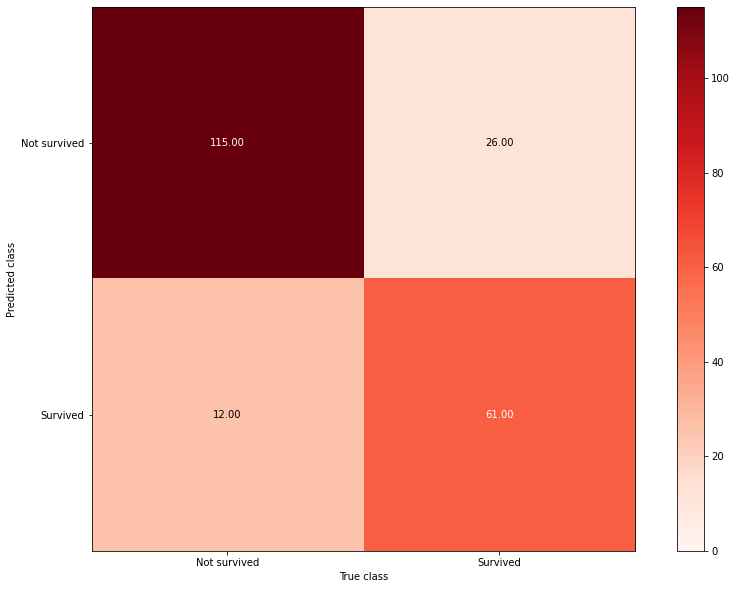

In [39]:
corr_im = plt.imshow(confusion_matrix, cmap="Reds", vmin=0)
corr_cbar = plt.colorbar(corr_im)

corr_array = corr_im.get_array()
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        cell_value = corr_array[i][j]
        if cell_value > 0.5*np.max(confusion_matrix):
            text_color = 'white'
        else:
            text_color = 'black'
        plt.text(i, j, '{:.2f}'.format(cell_value), color=text_color, ha='center', va='center')

plt.xticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])
plt.yticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])

plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.show()

In [40]:
print("Accuracy: ", metrics.accuracy_score(target_test, prediction_))

Accuracy:  0.822429906542056


### Visualization of the Decision Tree with the best max_depth

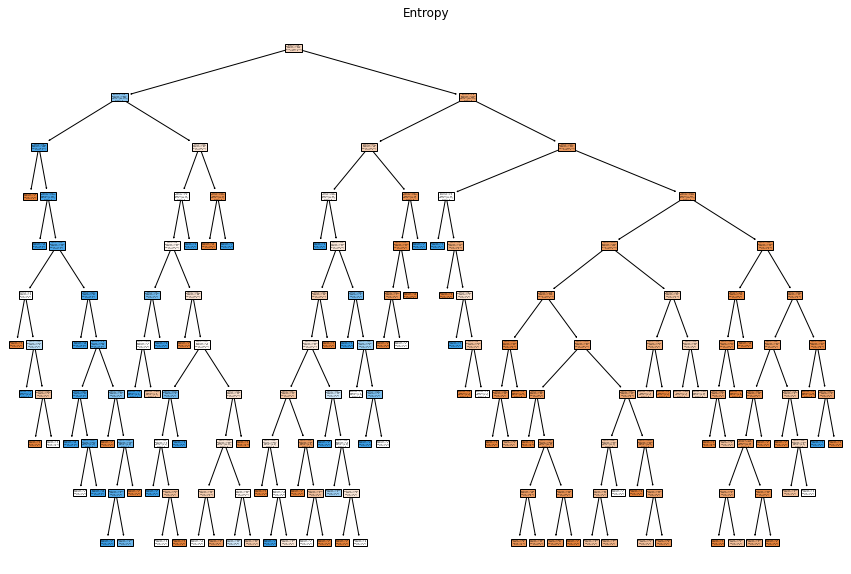

In [41]:
tree.plot_tree(model_best,
               feature_names = ["Pclass", "male", "Age"], 
               class_names= ['0','1'],
               filled = True)
plt.title("Entropy")
plt.show()

##### b. Make a visualization of the Decision Tree with max_depth = 3 using Graphviz.

In [42]:
model_best = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf =  clf.best_params_['min_samples_leaf'], 
                                    max_depth =  3)

In [43]:
model_best.fit(data_train, target_train)
prediction_ = model_best.predict(data_test)

In [44]:
# Obtain the confusion matrix here
confusion_matrix = metrics.confusion_matrix(target_test, prediction_)
confusion_matrix

array([[126,   1],
       [ 40,  47]], dtype=int64)

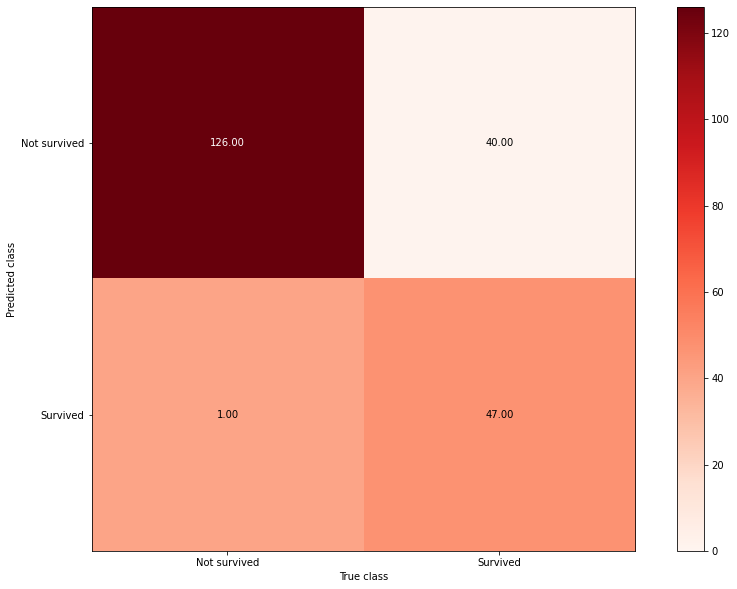

In [45]:
corr_im = plt.imshow(confusion_matrix, cmap="Reds", vmin=0)
corr_cbar = plt.colorbar(corr_im)

corr_array = corr_im.get_array()
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        cell_value = corr_array[i][j]
        if cell_value > 0.5*np.max(confusion_matrix):
            text_color = 'white'
        else:
            text_color = 'black'
        plt.text(i, j, '{:.2f}'.format(cell_value), color=text_color, ha='center', va='center')

plt.xticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])
plt.yticks(ticks=range(len(titanic_subdata.Survived.unique())), labels=["Not survived", "Survived"])

plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.show()

In [46]:
print("Accuracy: ", metrics.accuracy_score(target_test, prediction_))

Accuracy:  0.8084112149532711


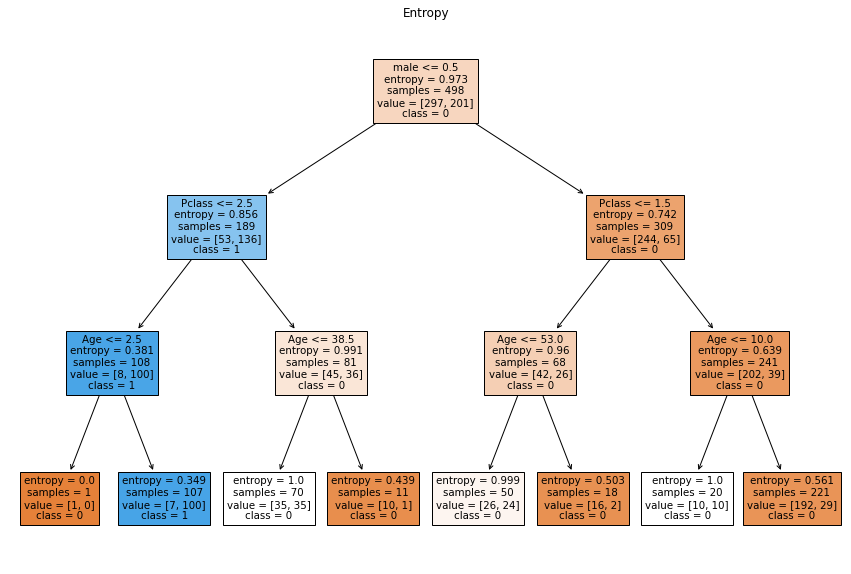

In [47]:
tree.plot_tree(model_best,
               feature_names = ["Pclass", "male", "Age"], 
               class_names= ['0','1'],
               filled = True)
plt.title("Entropy")
plt.show()